# Calcul du nombre de prélèvements CVM non conforme par commune et par année

L'objectif de ce notebook est de partir de la liste de communes cog_communes, et pour chaque commune et chaque année, calculer le nombre de prélèvements non conformes pour le CVM.

Il y aura plusieurs aggrégations à faire :

- commune (inseecommune) peut avoir plusieurs UDIs (cdreseau) **ET** un UDI peut avoir plusieurs communes (inseecommune) 
- un prélèvement (referenceprel) peut être rattaché à plusieurs UDIs (cdreseau)
- un prélèvement (referenceprel) peut être composé de plusieurs paramètres (cdparametresiseeaux) ; mais dans le cas du CVM, il y a un seul paramètre selon la catégorisation de Pauline, donc c'est plus simple




In [1]:
%load_ext sql
%sql duckdb:///../../database/data.duckdb
%config SqlMagic.displaylimit = 10

The 'toml' package isn't installed. To load settings from pyproject.toml or ~/.jupysql/config, install with: pip install toml

Connecting to 'duckdb:///../../database/data.duckdb'

In [2]:
%%sql
SELECT * FROM int__resultats_udi_communes
LIMIT 5

Running query in 'duckdb:///../../database/data.duckdb'

referenceprel,cdparametresiseeaux,valtraduite,limitequal,de_partition,limitequal_float,unite,categorie,cdreseau,inseecommune,datetimeprel
00200179905,TCEYTCL,0.000,<=10 µg/L,2020,10.0,µg/L,hydrocarbures,002001064,02114,2020-05-19 11:48:00
00200179905,TCLEY,0.000,<=10 µg/L,2020,10.0,µg/L,hydrocarbures,002001064,02114,2020-05-19 11:48:00
00200179905,THM4,25.600,<=100 µg/L,2020,100.0,µg/L,sous produit désinfection,002001064,02114,2020-05-19 11:48:00
00200179905,TOL,0.000,None,2020,None,None,hydrocarbures,002001064,02114,2020-05-19 11:48:00
00200179905,XYLMEPA,0.000,None,2020,None,None,hydrocarbures,002001064,02114,2020-05-19 11:48:00


**Pour le bilan annuel**

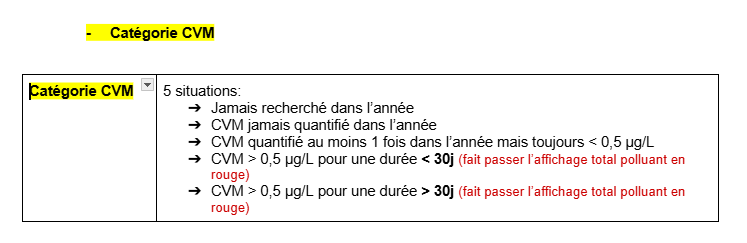


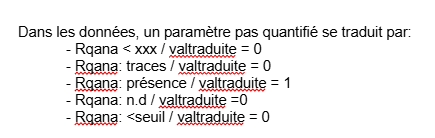

## Les résultats par uid - Bilan annuel

In [23]:
%%sql --save int__resultats_annuel_cvm_uid
WITH
communes_year AS (
    SELECT
        de_partition AS annee,
        categorie,
        cdreseau,
        cdparametresiseeaux,
        sum(1) AS nb_analyses,
        sum(CASE
            WHEN
                valtraduite = 0 OR valtraduite = 1 OR valtraduite IS NULL
                OR valtraduite IS NULL
                OR limitequal_float IS NULL
                THEN 1
            ELSE 0
        END) AS nb_analyses_not_quantify,
        sum(CASE
            WHEN
                limitequal_float IS NOT NULL AND valtraduite > limitequal_float
                AND valtraduite != 0
                THEN 1
            ELSE 0
        END) AS nb_analyses_not_ok,
        sum(CASE
            WHEN
                limitequal_float IS NOT NULL AND valtraduite <= limitequal_float
                AND valtraduite != 0
                THEN 1
            ELSE 0
        END) AS nb_analyses_ok
    FROM
        int__resultats_udi_communes
    WHERE
        categorie = 'cvm'
    GROUP BY
        annee,
        categorie,
        cdreseau,
        cdparametresiseeaux
)

SELECT
    communes_year.annee,
    communes_year.cdreseau,
    communes_year.categorie,
    communes_year.cdparametresiseeaux,
    'bilan annuel' AS periode,
    CASE
        WHEN communes_year.nb_analyses = 0
            THEN 'Pas recherché'
        WHEN
            communes_year.nb_analyses_not_quantify > 0
            AND communes_year.nb_analyses_ok = 0
            THEN 'non quantifié'
        WHEN
            communes_year.nb_analyses > 0
            AND communes_year.nb_analyses_not_ok >= 1
            THEN '> 0,5 µg/L'
        WHEN communes_year.nb_analyses > 0 AND communes_year.nb_analyses_ok >= 1
            THEN '<= 0,5 µg/L'
        ELSE 'Check SQL'
    END AS resultat
FROM
    communes_year


Running query in 'duckdb:///../../database/data.duckdb'

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

annee,cdreseau,categorie,cdparametresiseeaux,periode,resultat
2020,004000459,cvm,CLVYL,bilan annuel,non quantifié
2020,004000430,cvm,CLVYL,bilan annuel,non quantifié
2020,004000633,cvm,CLVYL,bilan annuel,non quantifié
2020,004001197,cvm,CLVYL,bilan annuel,"<= 0,5 µg/L"
2020,004001114,cvm,CLVYL,bilan annuel,non quantifié
2020,004000756,cvm,CLVYL,bilan annuel,non quantifié
2020,004001047,cvm,CLVYL,bilan annuel,non quantifié
2020,004000048,cvm,CLVYL,bilan annuel,"> 0,5 µg/L"
2020,004000603,cvm,CLVYL,bilan annuel,non quantifié
2020,004000595,cvm,CLVYL,bilan annuel,non quantifié


## Ajout du nombre de jours sur l'année

In [10]:
%%sql 
WITH
udi_year_days AS (
    SELECT
        de_partition AS annee,
        categorie,
        cdreseau,
        cdparametresiseeaux,
        datetimeprel,
        valtraduite,
        CASE
            WHEN
                valtraduite = 0
                OR valtraduite = 1
                OR valtraduite IS NULL
                OR limitequal_float IS NULL
                THEN 'non quantifié'
            WHEN
                valtraduite > limitequal_float
                THEN '> 0,5 µg/L'
            WHEN
                valtraduite <= limitequal_float
                THEN '<= 0,5 µg/L'
            ELSE 'Check SQL'
        END AS actual_resultats,
    FROM
        int__resultats_udi_communes
    WHERE
        categorie = 'cvm'
)
    SELECT
        annee,
        categorie,
        cdreseau,
        cdparametresiseeaux,
        datetimeprel,
        valtraduite,
        actual_resultats,
        LAG(datetimeprel) OVER ( PARTITION BY annee,categorie,cdreseau,cdparametresiseeaux ORDER BY datetimeprel ) AS previous_datetimeprel,
        LAG(actual_resultats) OVER (PARTITION BY annee,categorie,cdreseau,cdparametresiseeaux ORDER BY datetimeprel ) AS previous_resultats,
    FROM
        udi_year_days
/*WHERE
    cdreseau = '001001073'
    AND categorie = 'cvm'
    AND annee = '2023'
ORDER BY  datetimeprel
*/
-- ORDER BY annee,categorie,cdreseau,cdparametresiseeaux, datetimeprel

Running query in 'duckdb:///../../database/data.duckdb'

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

annee,categorie,cdreseau,cdparametresiseeaux,datetimeprel,valtraduite,actual_resultats,previous_datetimeprel,previous_resultats
2020,cvm,001000003,CLVYL,2020-02-13 11:40:00,0.000,non quantifié,None,None
2020,cvm,001000003,CLVYL,2020-10-12 09:15:00,0.000,non quantifié,2020-02-13 11:40:00,non quantifié
2020,cvm,001000241,CLVYL,2020-01-24 09:49:00,0.000,non quantifié,2020-01-24 09:49:00,non quantifié
2020,cvm,001000241,CLVYL,2020-01-24 09:49:00,0.000,non quantifié,2020-01-24 09:49:00,non quantifié
2020,cvm,001000241,CLVYL,2020-01-24 09:49:00,0.000,non quantifié,2020-01-24 09:49:00,non quantifié
2020,cvm,001000241,CLVYL,2020-01-24 09:49:00,0.000,non quantifié,2020-01-24 09:49:00,non quantifié
2020,cvm,001000241,CLVYL,2020-01-24 09:49:00,0.000,non quantifié,2020-01-24 09:49:00,non quantifié
2020,cvm,001000241,CLVYL,2020-01-24 09:49:00,0.000,non quantifié,2020-01-24 09:49:00,non quantifié
2020,cvm,001000241,CLVYL,2020-01-24 09:49:00,0.000,non quantifié,2020-01-24 09:49:00,non quantifié
2020,cvm,001000241,CLVYL,2020-01-24 09:49:00,0.000,non quantifié,2020-01-24 09:49:00,non quantifié


In [23]:
%%sql 
WITH
udi_year_days AS (
    SELECT
        de_partition AS annee,
        categorie,
        cdreseau,
        cdparametresiseeaux,
        datetimeprel,
        valtraduite,
        CASE
            WHEN
                valtraduite = 0
                OR valtraduite = 1
                OR valtraduite IS NULL
                OR limitequal_float IS NULL
                THEN 'non quantifié'
            WHEN
                valtraduite > limitequal_float
                THEN '> 0,5 µg/L'
            WHEN
                valtraduite <= limitequal_float
                THEN '<= 0,5 µg/L'
            ELSE 'Check SQL'
        END AS actual_resultats,
    FROM
        int__resultats_udi_communes
    WHERE
        categorie = 'cvm'
),

udi_year_days_previous AS (
    SELECT
        annee,
        categorie,
        cdreseau,
        cdparametresiseeaux,
        datetimeprel,
        valtraduite,
        actual_resultats,
        LAG(datetimeprel) OVER ( PARTITION BY annee,categorie,cdreseau,cdparametresiseeaux ORDER BY datetimeprel ) AS previous_datetimeprel,
        LAG(actual_resultats) OVER (PARTITION BY annee,categorie,cdreseau,cdparametresiseeaux ORDER BY datetimeprel ) AS previous_resultats,
    FROM
        udi_year_days
)

SELECT
    annee,
    categorie,
    cdreseau,
    cdparametresiseeaux,
    previous_resultats AS resultats,
    DATE_DIFF ('day', previous_datetimeprel , datetimeprel ) AS nb_days_intervall,
FROM
    udi_year_days_previous
WHERE 
    previous_resultats IS NOT NULL

Running query in 'duckdb:///../../database/data.duckdb'

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

annee,categorie,cdreseau,cdparametresiseeaux,resultats,nb_days_intervall
2022,cvm,059000552,CLVYL,"<= 0,5 µg/L",0
2022,cvm,059000552,CLVYL,"<= 0,5 µg/L",48
2022,cvm,059000552,CLVYL,"<= 0,5 µg/L",0
2022,cvm,059000552,CLVYL,"<= 0,5 µg/L",0
2022,cvm,059000552,CLVYL,"<= 0,5 µg/L",0
2022,cvm,059000552,CLVYL,"<= 0,5 µg/L",0
2022,cvm,059000552,CLVYL,"<= 0,5 µg/L",9
2022,cvm,059000552,CLVYL,non quantifié,0
2022,cvm,059000552,CLVYL,non quantifié,0
2022,cvm,059000552,CLVYL,non quantifié,0


In [28]:
%%sql --save int__resultats_annuel_cvm_uid_with_dayscount
WITH
udi_year_days AS (
    SELECT
        de_partition AS annee,
        categorie,
        cdreseau,
        cdparametresiseeaux,
        datetimeprel,
        valtraduite,
        CASE
            WHEN
                valtraduite = 0
                OR valtraduite = 1
                OR valtraduite IS NULL
                OR limitequal_float IS NULL
                THEN 'non quantifié'
            WHEN
                valtraduite > limitequal_float
                THEN '> 0,5 µg/L'
            WHEN
                valtraduite <= limitequal_float
                THEN '<= 0,5 µg/L'
            ELSE 'Check SQL'
        END AS actual_resultats,
    FROM
        int__resultats_udi_communes
    WHERE
        categorie = 'cvm'
),

udi_year_days_previous AS (
    SELECT
        annee,
        categorie,
        cdreseau,
        cdparametresiseeaux,
        datetimeprel,
        valtraduite,
        actual_resultats,
        LAG(datetimeprel) OVER ( PARTITION BY annee,categorie,cdreseau,cdparametresiseeaux ORDER BY datetimeprel ) AS previous_datetimeprel,
        LAG(actual_resultats) OVER (PARTITION BY annee,categorie,cdreseau,cdparametresiseeaux ORDER BY datetimeprel ) AS previous_resultats,
    FROM
        udi_year_days
),

udi_year_days_count AS (
    SELECT
        annee,
        categorie,
        cdreseau,
        cdparametresiseeaux,
        previous_resultats AS resultats,
        DATE_DIFF ('day', previous_datetimeprel , datetimeprel ) AS nb_days_intervall,
    FROM
        udi_year_days_previous
    WHERE 
        previous_resultats IS NOT NULL
),

udi_year_days_count_per_result AS(
    SELECT
        annee,
        categorie,
        cdreseau,
        cdparametresiseeaux,
        SUM(CASE WHEN resultats ='<= 0,5 µg/L' THEN nb_days_intervall END ) AS  nb_days_ok,
        SUM(CASE WHEN resultats = '> 0,5 µg/L' THEN nb_days_intervall END ) AS  nb_days_ko,
        SUM(CASE WHEN resultats = 'non quantifié' THEN nb_days_intervall END ) AS  nb_days_non_quantifié,
        SUM(nb_days_intervall) AS total_days
    FROM
        udi_year_days_count
GROUP BY 
        annee,
        categorie,
        cdreseau,
        cdparametresiseeaux
)

    SELECT
        annee,
        categorie,
        cdreseau,
        cdparametresiseeaux,
        COALESCE(MAX(nb_days_ok),0) AS  nb_days_ok,
        COALESCE(MAX(nb_days_ko),0) AS  nb_days_ko,
        COALESCE(MAX(nb_days_non_quantifié),0) AS  nb_days_non_quantifié,
        COALESCE(MAX(total_days),0) AS  total_days,
        COALESCE(MAX(nb_days_ko),0) /  COALESCE(MAX(total_days),0) AS percent_ko
    FROM
        udi_year_days_count_per_result
GROUP BY 
        annee,
        categorie,
        cdreseau,
        cdparametresiseeaux

Running query in 'duckdb:///../../database/data.duckdb'

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

annee,categorie,cdreseau,cdparametresiseeaux,nb_days_ok,nb_days_ko,nb_days_non_quantifié,total_days,percent_ko
2024,cvm,034001052,CLVYL,0,0,36,36,0.0
2024,cvm,037000386,CLVYL,0,0,46,46,0.0
2024,cvm,038000540,CLVYL,0,0,147,147,0.0
2024,cvm,038001786,CLVYL,0,0,185,185,0.0
2024,cvm,042000728,CLVYL,119,0,107,226,0.0
2024,cvm,042000767,CLVYL,0,0,56,56,0.0
2024,cvm,046000416,CLVYL,0,0,225,225,0.0
2024,cvm,051002944,CLVYL,0,0,248,248,0.0
2024,cvm,053003547,CLVYL,0,0,88,88,0.0
2024,cvm,054000362,CLVYL,0,0,130,130,0.0
